In [1]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

In [2]:
data_path_train = r'C:\Users\Steven\OneDrive - Cal State LA\Documents\train_metadata.json'
with open(data_path_train) as json_file:
    meta_train = json.load(json_file)
    
    
#loading json file for test data
data_path_test = r'C:\Users\Steven\OneDrive - Cal State LA\Documents\test_metadata.json'
with open(data_path_test) as json_file:
    meta_test = json.load(json_file) 

In [3]:
#Finding keys in train dictionary
meta_train.keys()

dict_keys(['annotations', 'images', 'categories', 'genera', 'institutions', 'distances', 'license'])

In [4]:
#creating seperate dataframes from metadata
annotations_train =  pd.json_normalize(meta_train ['annotations'])
categories_train =  pd.json_normalize(meta_train ['categories'])
images_train =  pd.json_normalize(meta_train ['images'])
genera_train =  pd.json_normalize(meta_train ['genera'])
distance_train =  pd.json_normalize(meta_train ['distances'])
licenses_train =  pd.json_normalize(meta_train ['license'])
institutions_train =  pd.json_normalize(meta_train ['institutions'])

In [5]:

#categories_train['species']=categories_train['species'].astype('category').cat.codes



In [6]:
del genera_train
del licenses_train
del institutions_train

In [7]:
#Looking at test set
df_test = pd.DataFrame(meta_test)

#creating test data
df_test = df_test.drop(['license'], axis=1)

print(df_test['file_name'])
# adding file path
df_test = df_test[['image_id','file_name']]
df_test['file_path']='C:/Users/Steven/OneDrive - Cal State LA/Documents/image/'+df_test['file_name']


0         000/test-000000.jpg
1         000/test-000001.jpg
2         000/test-000002.jpg
3         000/test-000003.jpg
4         000/test-000004.jpg
                 ...         
210402    223/test-223645.jpg
210403    223/test-223646.jpg
210404    223/test-223647.jpg
210405    223/test-223648.jpg
210406    223/test-223649.jpg
Name: file_name, Length: 210407, dtype: object


In [8]:
# Complete df
df_merge = pd.merge(images_train[['image_id','file_name']],annotations_train[['genus_id','category_id','image_id']] , on='image_id')
df_merge = pd.merge(df_merge[['genus_id','image_id','file_name','category_id']],categories_train[['category_id','scientificName','family','genus','species']] , on='category_id')
df_merge['file_path']='C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/'+df_merge['file_name']
df_merge['name']=df_merge['genus']+' '+df_merge['species']
df_train = df_merge[['category_id','genus_id','image_id','family','genus','species','name','file_name','file_path']]

df_train.head()

,category_id,genus_id,image_id,family,genus,species,name,file_name,file_path
0,0,1,00000__001,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__001.jpg,C:/Users/Steven/OneDrive - Cal State LA/Docume...
1,0,1,00000__002,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__002.jpg,C:/Users/Steven/OneDrive - Cal State LA/Docume...
2,0,1,00000__003,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__003.jpg,C:/Users/Steven/OneDrive - Cal State LA/Docume...
3,0,1,00000__004,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__004.jpg,C:/Users/Steven/OneDrive - Cal State LA/Docume...
4,0,1,00000__005,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__005.jpg,C:/Users/Steven/OneDrive - Cal State LA/Docume...


In [75]:
#df_train['category_id'][78]
df_train['file_path'][54]


'C:/Users/Steven/OneDrive - Cal State LA/Documents/images2/000/00/00000__071.jpg'

(665, 600)


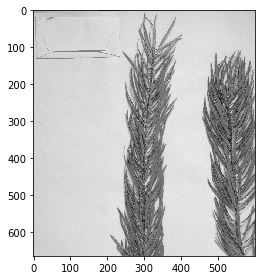

In [106]:
img=imread(df_train['file_path'][150], as_gray=True)
img=img[0:665,0:600]
print(img.shape)
imshow(img)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


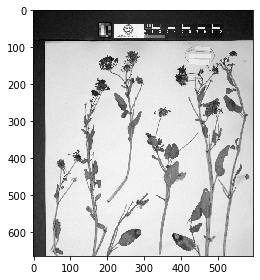

In [107]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
y=[]
def makeimage(i2,img2):
    #image=mpimg.imread(df_train['file_path'][i2])
    img=imread(df_train['file_path'][i2])
    img=img[0:665,0:595]
    imshow(img[0:665,0:600])
    img2.append(np.reshape(img, (665*595)))
    y.append(df_train['category_id'][i2])
    print(len(y))
    #feature_matrix = np.zeros((1000,626) )
    #feature_matrix.shape

    #for i in range(0,1000):
     #   for j in range(0,626):
     #       feature_matrix[i][j] = ((int(image[i,j,0]) + int(image[i,j,1]) + int(image[i,j,2]))/3)

    #features = np.reshape(feature_matrix, (1000*626)) 
    #features.shape

    #print(features)


i2=0
img2=[]
while i2<1000:
    makeimage(i2,img2)
    i2=i2+1


In [108]:
img2=np.array(img2)
print(np.array(img2).shape)

(1000, 395675)


In [109]:

dff=pd.DataFrame(y,columns = ['Name'])
y=dff['Name']
print(y)
from sklearn import preprocessing
X=img2
#c
#X=preprocessing.scale(X)


0       0
1       0
2       0
3       0
4       0
       ..
995    18
996    18
997    18
998    18
999    18
Name: Name, Length: 1000, dtype: int64


In [110]:
from sklearn.model_selection import train_test_split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=500)
print(X_train)
print(y_train)

[[-0.57550515 -0.40381528 -0.38270297 ... -0.22729738 -0.27212505
  -0.18668005]
 [-0.31343286 -0.2741218  -0.32798882 ... -0.04728261 -0.08625701
  -0.09669289]
 [-0.63929708 -0.65062069 -0.65212203 ...  0.78577493  0.80427129
   0.7782269 ]
 ...
 [-0.38907579 -0.36272961 -0.37579154 ... -0.71498575 -0.76264239
  -0.59496787]
 [-0.13216093 -0.22097982 -0.19094729 ...  0.16759689  0.1052259
   0.11409311]
 [-0.63929708 -0.65062069 -0.65212203 ...  0.73747692  0.75440285
   0.73084898]]
703    14
311     4
722    14
629    10
0       0
       ..
106     1
270     4
860    16
435     6
102     1
Name: Name, Length: 670, dtype: int64


In [112]:

from sklearn.neural_network import MLPClassifier



model = MLPClassifier( random_state=1, hidden_layer_sizes=(30,),learning_rate_init = 0.02, solver='adam', alpha=1, verbose=False, activation='logistic')

In [113]:


fitted_model2 = model.fit(X_train, y_train)

# Prediction:
model.predict(X_test)
model.score(X_test,y_test)
#cm=confusion_matrix(y_predict, y_test)
#print('The accuracy is: ', accuracy(cm))

0.13636363636363635

In [ ]:

from  sklearn.model_selection  import  GridSearchCV

seed= 1
np.random.seed(seed)



neurons = [] 

i=5

while i<=250:
    neurons.append(i)
    i=i+5
print(neurons)


lst_tuple = [x for x in zip(*[iter(neurons)])]
print(lst_tuple)



from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
GRID = [
    {
     'estimator': [MLPClassifier(random_state=seed)],
     'estimator__solver': ['adam'],
     'estimator__learning_rate_init': [0.02],
     'estimator__hidden_layer_sizes': lst_tuple,
     'estimator__activation': ['logistic'],
     'estimator__alpha': [1]
     }
]

PIPELINE = Pipeline([('scaler', None), ('estimator', MLPClassifier())])

grid_search = GridSearchCV(estimator=PIPELINE, param_grid=GRID, 
                            scoring='accuracy', cv=10, verbose=True, 
                            )

grid_search.fit(X, y)






[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250]
[(5,), (10,), (15,), (20,), (25,), (30,), (35,), (40,), (45,), (50,), (55,), (60,), (65,), (70,), (75,), (80,), (85,), (90,), (95,), (100,), (105,), (110,), (115,), (120,), (125,), (130,), (135,), (140,), (145,), (150,), (155,), (160,), (165,), (170,), (175,), (180,), (185,), (190,), (195,), (200,), (205,), (210,), (215,), (220,), (225,), (230,), (235,), (240,), (245,), (250,)]
Fitting 10 folds for each of 50 candidates, totalling 500 fits


C:\Users\Steven\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


In [ ]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))